In [1]:
# Performing PCA and k-means clustering on the molecular dynamics trajectories, along with the visualisation of key interatomic distance in the discrete states
# Imports
import pyemma
import re
import os
import string
import matplotlib.pyplot as plt
import numpy as np
import pyemma.msm as msm
import pyemma.plots as mplt
import pyemma.coordinates as coor
from matplotlib.axes import Axes
import seaborn as sns
import molpx

_ColormakerRegistry()

In [2]:
# Changing directory to where the required files are located
os.chdir('E:\\google_disk\\doktorat\\programming\\pyemma_pca\\')

In [3]:
# Function for fitting and transforming trajectory using either tica or pca and clustering the resultant data
def project_and_cluster(trajfiles, featurizer, sparsify=False, tica=False, lag=1, scale=True, var_cutoff=0.95, ncluster=4):
    X = coor.load(trajfiles,featurizer)
    if sparsify:
        X = remove_constant(X)
    if tica:
        trans_obj = coor.tica(X, dim=-1, kinetic_map=False)
    else:
        trans_obj = coor.pca(X, dim=-1, var_cutoff=var_cutoff)
    Y = trans_obj.get_output()
    if scale:
        for y in Y:
            y *= trans_obj.eigenvalues[:trans_obj.dimension()]
    cl_obj = coor.cluster_kmeans(Y, k=ncluster, max_iter=50, fixed_seed=True)
    return trans_obj, Y, cl_obj

In [4]:
# Function for making data sparse, if threshold is met
def remove_constant(X, threshold=0.001):
    if isinstance(X, np.ndarray):
        X = [X]
        Ds = [np.max(x, axis=0) - np.min(x, axis=0) for x in X]
        D = np.min(np.array(Ds), axis=0)
        Ivar = np.where(D > 0.001)[0]
        Y = [x[:, Ivar] for x in X]
        if len(Y) == 1:
            Y = Y[0]
        return Y

In [5]:
# Loading topology and parameter files
top = 'topology_4zaf.prmtop'
trajs = 'traj_short.nc'

In [6]:
# Choosing feature - herein I chose Ca carbon atoms in the protein backbone
feat = coor.featurizer(top)
sele = feat.select_Ca()
feat.add_selection(indexes=sele)

In [7]:
# Defining the source for trajectectory along with the features to be used for PCA
source = pyemma.coordinates.source(trajs,feat)

In [8]:
# PCA transformation, along with k-means clustering of the results
pca_vc0_75, pca_Y_vc0_75, pca_cl_vc0_75 = project_and_cluster(trajs, feat, sparsify=True, tica=False)

In [9]:
# Printing what is the shape of the data: first 
Y=pca_Y_vc0_75[0]
print(f'Projected data shape:\nNumber of trajectory frames: {Y.shape[0]}\nNumber of dimensions after PCA transformation: {Y.shape[1]}')

Projected data shape:
Number of trajectory frames: 500
Number of dimensions after PCA transformation: 118


In [10]:
# Defining clusters as a trajectory
dtrajs_pca = pca_cl_vc0_75.dtrajs

In [11]:
# Defining coordinates of clusters in the first two principal component space (mapping clusters onto PCA)
cc_xpca = pca_cl_vc0_75.clustercenters[:,0]
cc_ypca = pca_cl_vc0_75.clustercenters[:,1]

In [12]:
# Defining molpx path - it enables saving clusters as trajectories; it might take a few minutes
paths_dict, idata = molpx.generate.projection_paths(trajs,
                                                    top,
                                                    Y,
                                                    n_points=100,
                                                    n_geom_samples=100,
                                                    n_projs=2,
                                                    proj_dim = 2,
                                                    verbose=False,
                                        )

In [13]:
# Running molpx
coord = 0
path_type = 'min_disp'
igeom = paths_dict[coord][path_type]["geom"]
ipath = paths_dict[coord][path_type]["proj"]
np.save('paths_pca.dict.npy', paths_dict)
igeom.save_pdb('pca_ca.pdb')
np.save('ipath.txt', ipath)
proj_idxs = [0,1]

In [14]:
# Defining which distance between two atoms in the obtained clusters should be considered
feat_cat=pyemma.coordinates.featurizer(top)
at1=feat_cat.select("(name C4)")[0]
at2=feat_cat.select("(name N22)")[0]
dist=[at1,at2]
feat_cat.add_distances(dist)
D_dist=pyemma.coordinates.load(trajs,features=feat_cat)

11-10-19 15:05:52 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[16] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


In [15]:
# Finding the actual distances in 4 most relevant clusters
nclusters=4
clusters_dist={'clusters':[],'valors':[]}
for disc_traj in range(0,len(dtrajs_pca[0])):
    clusters_dist["clusters"].append(dtrajs_pca[0][disc_traj])
    clusters_dist["valors"].append(D_dist[disc_traj][0])   
dmeans_dist=[]
valors_dist=[]
for cluster in range(0,nclusters):
    valor=[]
    for element in range(0,len(clusters_dist["clusters"])):
        if clusters_dist["clusters"][element] == cluster:
            valor.append(clusters_dist["valors"][element])
    valors_dist.append(valor)

In [16]:
# Appending distance and standard deviation to individual list, containing only relevant data
dmeans=[]
dstd=[]
for valor in valors_dist:
    dmeans.append(np.mean(valor)*10)
    dstd.append(np.std(valor)*10)

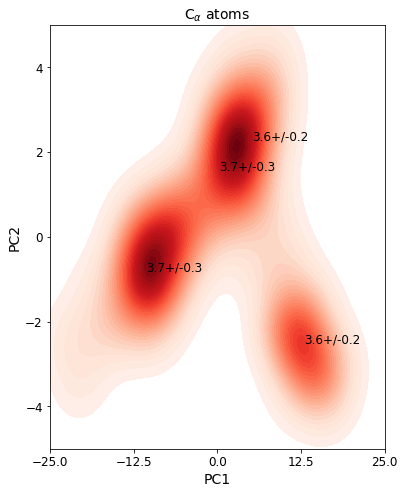

In [17]:
# Plotting results of PCA along with the distance between considered atoms in the localized clusters
plt.figure(figsize=(6,7.8))
plt.title(r'C$_\alpha$ atoms', fontsize=14)
plt.xlabel('PC1', fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(xmin=-25.0)
plt.xlim(xmax=25.0)
plt.ylim(ymin=-5)
plt.ylim(ymax=5) # adjust the max leaving min unchanged
for i in range(nclusters):
    plt.annotate("%3.1f"%(dmeans[i])+"+/-"+"%3.1f"%(dstd[i]), xy=(cc_xpca[i],cc_ypca[i]),fontsize="12")
ax = sns.kdeplot(Y[:,0],Y[:,1],shade=True,shade_lowest=False,cmap="Reds",n_levels=40)
ax.xaxis.set_major_locator(plt.MultipleLocator(12.5))